# COVID19 evolution analysis

#### data loading

In [40]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tools
import plotly.express as px
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
df_naz = pd.read_csv('../../external_data/ProtezioneCivile/COVID-19/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv').drop('stato',1)
reg = pd.read_csv('../../external_data/ProtezioneCivile/COVID-19/dati-regioni/dpc-covid19-ita-regioni.csv')
prov = pd.read_csv('../../external_data/ProtezioneCivile/COVID-19/dati-province/dpc-covid19-ita-province.csv').drop('stato',1)
df_naz.index = pd.to_datetime(df_naz.index)
reg['data'] = pd.to_datetime(reg['data'])
prov['data'] = pd.to_datetime(prov['data'])
df_world_confirmed = pd.read_csv('../../external_data/JohnHopkins/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
df_world_deaths = pd.read_csv('../../external_data/JohnHopkins/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')
df_world_recovered = pd.read_csv('../../external_data/JohnHopkins/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')
populations = pd.read_csv('../../external_data/population_data/API_SP.POP.TOTL_DS2_en_csv_v2_866861.csv', skiprows=4, engine='python').set_index('Country Name')['2018']
df_world_confirmed['pop'] = df_world_confirmed['Country/Region'].map(populations)
df_world_deaths['pop'] = df_world_deaths['Country/Region'].map(populations)
df_world_recovered['pop'] = df_world_recovered['Country/Region'].map(populations)
df_naz = tools.add_extra_features(df_naz)
regions = reg.groupby('denominazione_regione')
df_reg = {}
for item in regions.groups:
    df_reg[item] = tools.add_extra_features(regions.get_group(item)).replace((np.inf, np.nan), 0)
provinces = prov.groupby('sigla_provincia')
df_prov = pd.DataFrame()
for item in provinces.groups:
    df_prov = pd.concat((df_prov,tools.add_extra_features(provinces.get_group(item)).replace((np.inf, np.nan), 0)),0)

In [42]:
date_cols = [item for item in df_world_confirmed.columns if '/20' in item]

In [43]:
df_world_confirmed.pivot_table(index='Country/Region', values=date_cols)

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/18/20,3/19/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.0,22.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0
Albania,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,59.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
Algeria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,74.0,87.0,3.0,5.0,12.0,12.0,17.0,17.0,19.0,20.0
Andorra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39.0,53.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Antigua and Barbuda,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Uruguay,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,50.0,79.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Uzbekistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Venezuela,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,36.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Italy

### diffusion heatmap for provinces

In [44]:
col = 'totale_casi'
fig = px.density_mapbox(df_prov[df_prov.index==df_prov.index.max()], 
                        lat='lat', lon='long', z=col, radius=10, 
                        hover_name='denominazione_provincia',
                        zoom=5,  height=800,
                        #animation_frame=df_prov[df_prov.index==df_prov.index.max()].index,
                        mapbox_style="stamen-terrain",
                        title = col + ' on ' + str(df_prov.index.max()))
fig.show()

In [45]:
col = '%delta_totale_casi'
fig = px.density_mapbox(df_prov[df_prov.index==df_prov.index.max()], 
                        lat='lat', lon='long', z=col, radius=10, 
                        hover_name='denominazione_provincia',
                        zoom=5,  height=800,
                        #animation_frame=df_prov.index,
                        mapbox_style="stamen-terrain",
                        title = col + ' on ' + str(df_prov.index.max()))
fig.show()

### National evolution

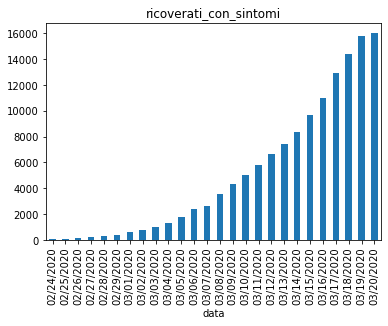

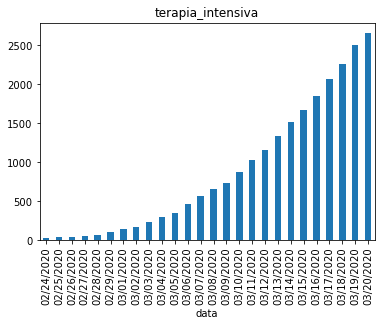

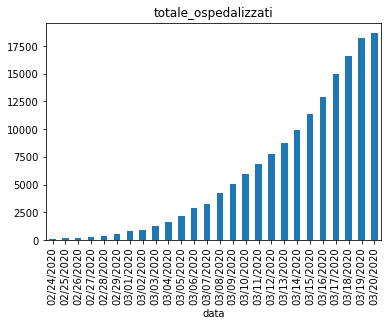

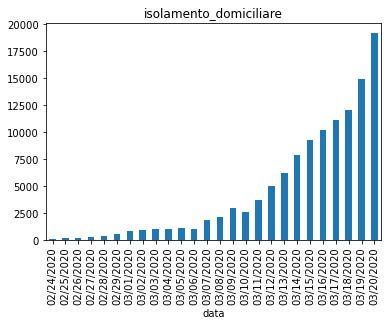

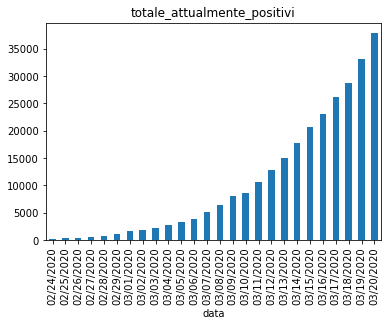

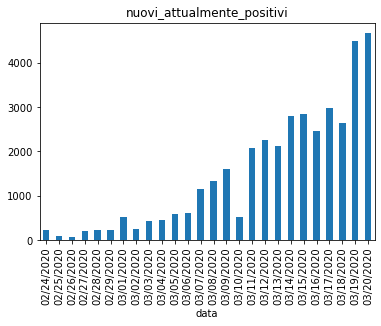

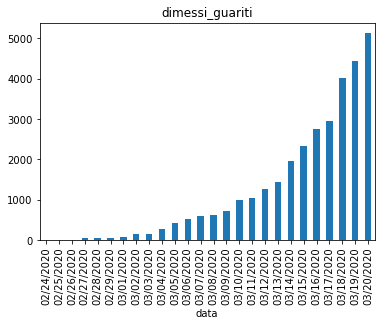

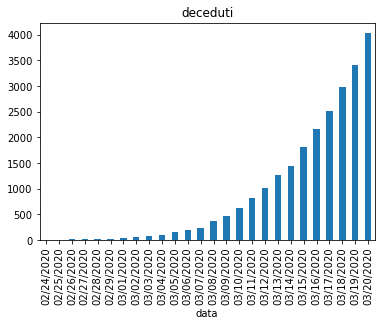

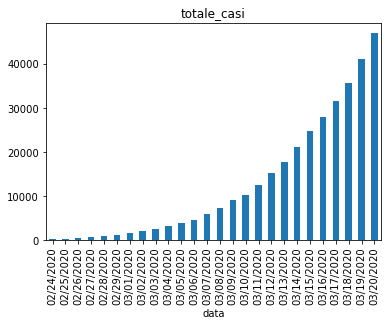

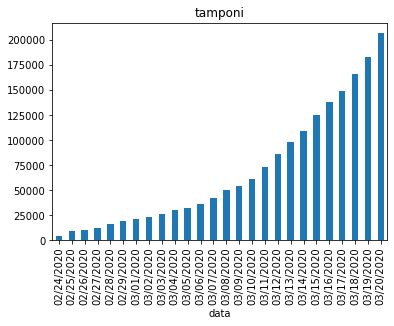

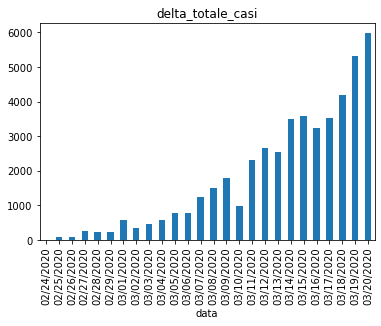

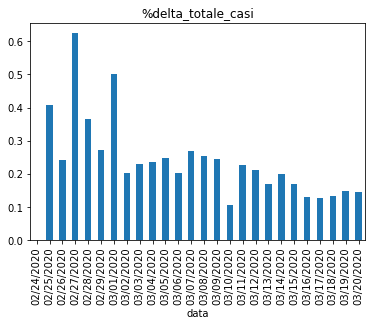

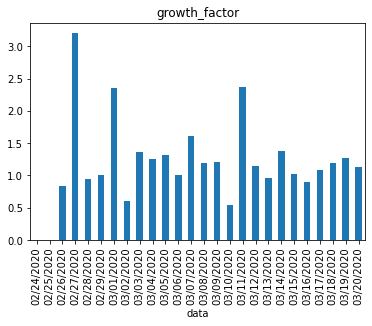

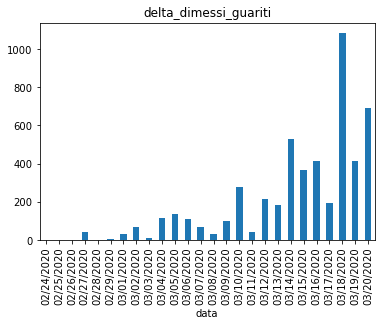

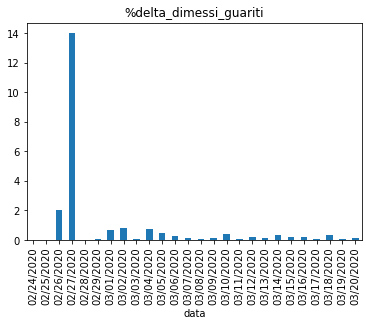

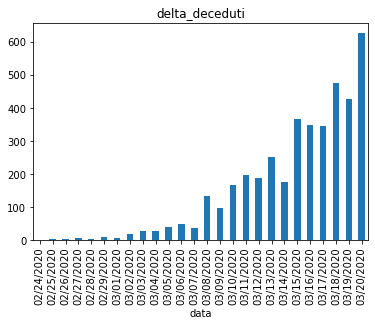

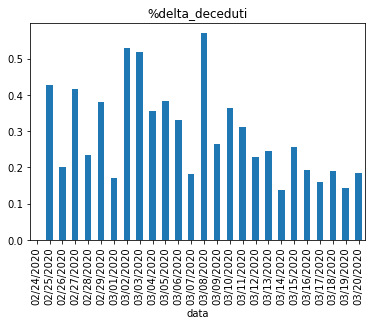

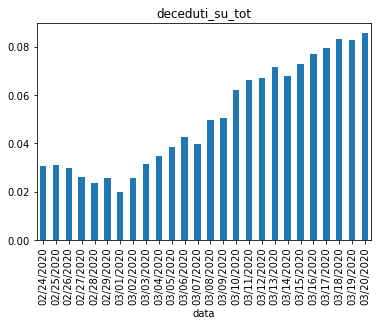

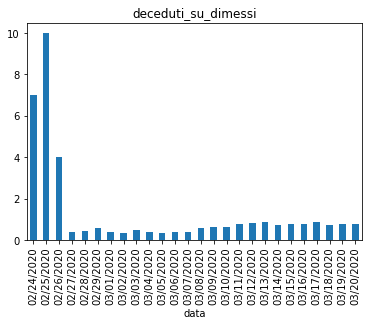

In [46]:
for col in df_naz.columns:
    plt.figure()
    df_naz[col].plot(kind='bar', title=col)    

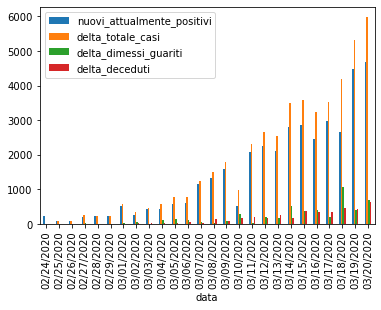

In [49]:
df_naz[['nuovi_attualmente_positivi', 'delta_totale_casi','delta_dimessi_guariti','delta_deceduti']].plot(kind='bar')

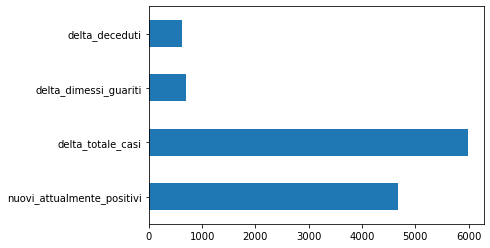

In [50]:
df_naz[['nuovi_attualmente_positivi', 'delta_totale_casi','delta_dimessi_guariti','delta_deceduti']].iloc[-1].plot(kind='barh')

Text(0.5, 1.0, "variazione giornaliera nuovi casi per l'Abruzzo")

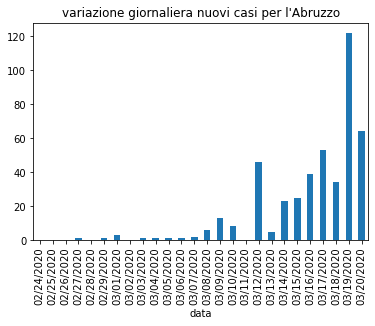

In [51]:
df_reg['Abruzzo']['delta_totale_casi'].plot(kind='bar')
plt.title("variazione giornaliera nuovi casi per l'Abruzzo")

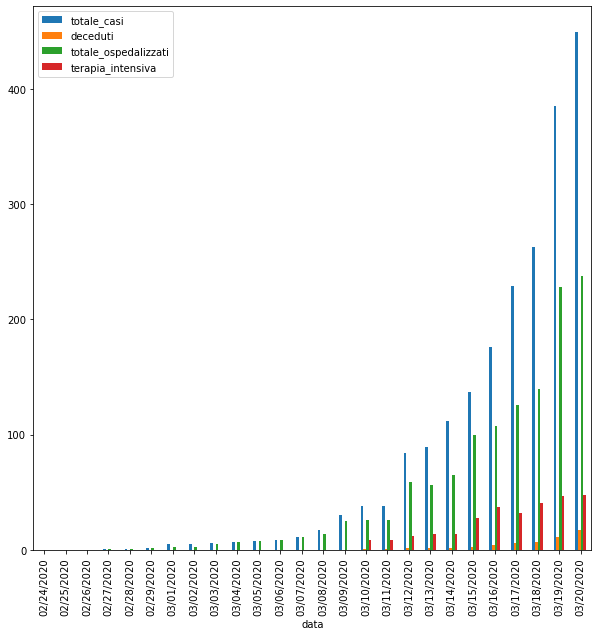

In [52]:
df_reg['Abruzzo'][['totale_casi', 'deceduti', 'totale_ospedalizzati', 'terapia_intensiva']].plot(kind='bar', figsize=(10,10))

### Logistic model evolution

### National Analysis

C:\Users\Maurizio Spadaccino\Documents\projects\coronavirus\notebooks\tools.py:112: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



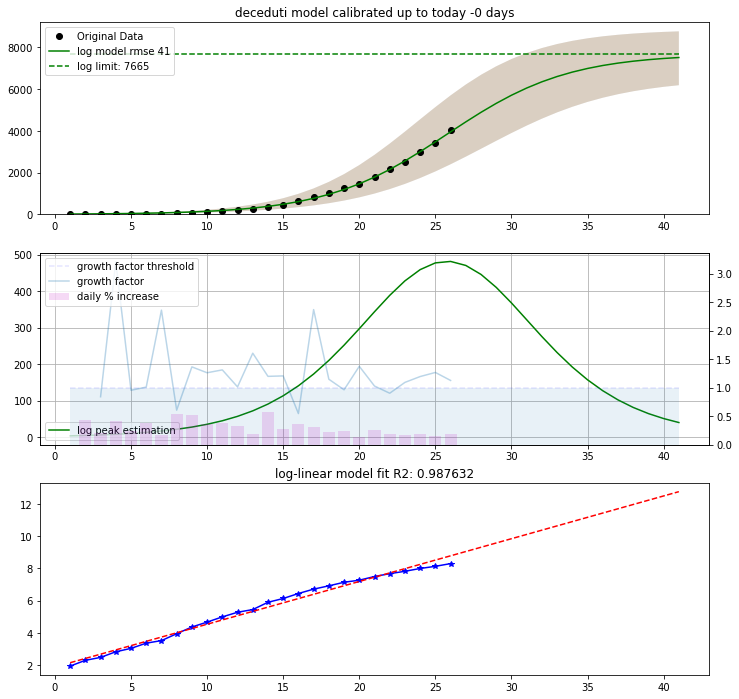

next day prediction for log model:  4432
data
03/16/2020    2158
03/17/2020    2503
03/18/2020    2978
03/19/2020    3405
03/20/2020    4032
Name: deceduti, dtype: int64


In [53]:
tools.plot_model(df_naz, 'deceduti', backward_fit=0, stdev=2, forward_look=15, plotdifferential=True, plotlimit=True, show_pol=False, show_exp=False)

C:\Users\Maurizio Spadaccino\Documents\projects\coronavirus\notebooks\tools.py:112: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



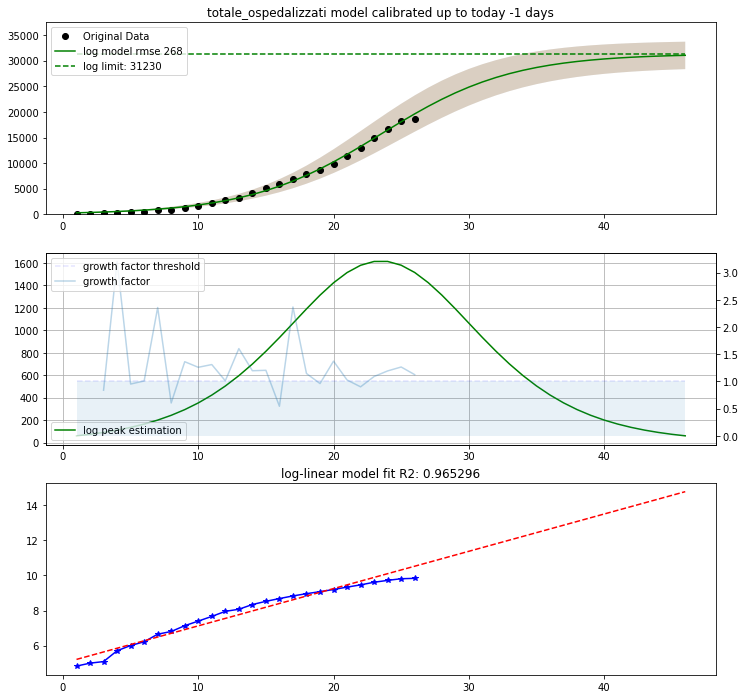

next day prediction for log model:  21098
data
03/16/2020    12876
03/17/2020    14954
03/18/2020    16620
03/19/2020    18255
03/20/2020    18675
Name: totale_ospedalizzati, dtype: int64


In [84]:
tools.plot_model(df_naz, 'totale_ospedalizzati', backward_fit=1, forward_look=20, plotlimit=True, show_pol=False, show_exp=False)

### Regional Analysis

C:\Users\Maurizio Spadaccino\Documents\projects\coronavirus\notebooks\tools.py:112: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



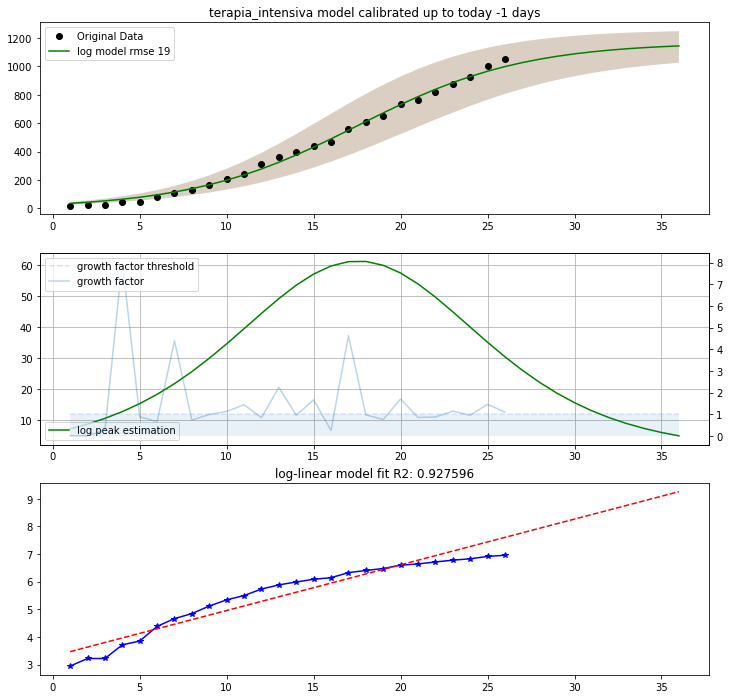

next day prediction for log model:  1027
data
03/16/2020     823
03/17/2020     879
03/18/2020     924
03/19/2020    1006
03/20/2020    1050
Name: terapia_intensiva, dtype: int64


In [59]:
tools.plot_model(df_reg['Lombardia'], 'terapia_intensiva', backward_fit=1, stdev=2, forward_look=10, plotlimit=False, 
                 show_pol=False, show_exp=False)

C:\Users\Maurizio Spadaccino\Documents\projects\coronavirus\notebooks\tools.py:112: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



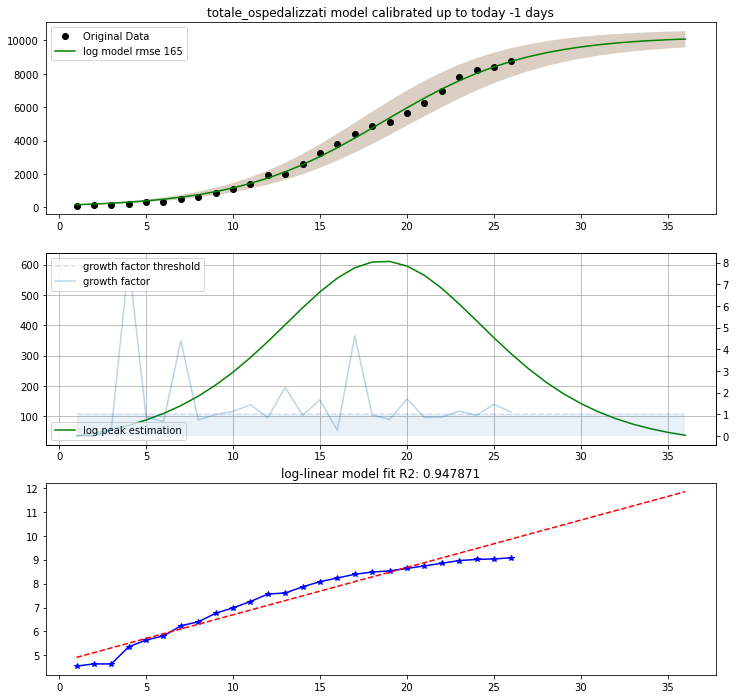

next day prediction for log model:  9027
data
03/16/2020    6994
03/17/2020    7832
03/18/2020    8209
03/19/2020    8393
03/20/2020    8785
Name: totale_ospedalizzati, dtype: int64


In [62]:
tools.plot_model(df_reg['Lombardia'], 'totale_ospedalizzati', backward_fit=1, forward_look=10, plotlimit=False, 
                 show_pol=False, show_exp=False)

C:\Users\Maurizio Spadaccino\Documents\projects\coronavirus\notebooks\tools.py:112: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



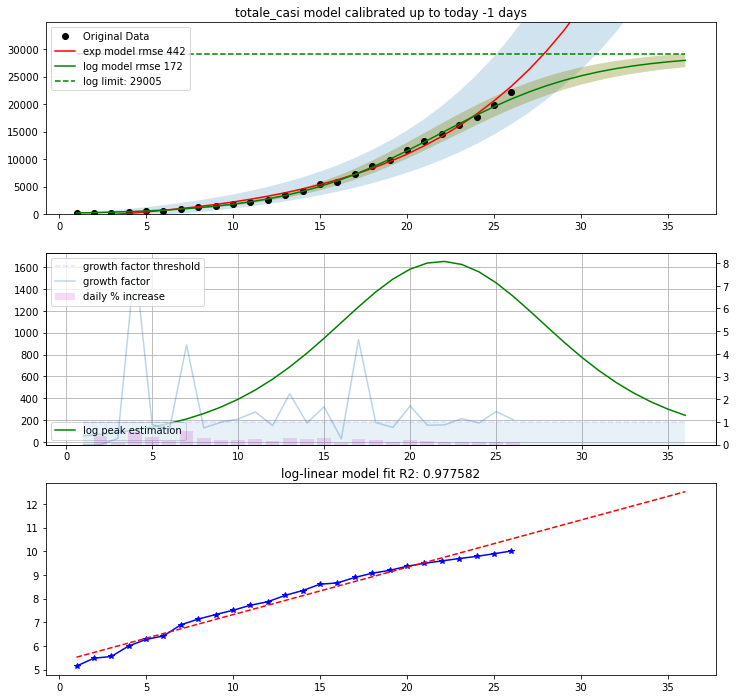

next day prediction for log model:  22185
next day prediction for exp model:  26207
data
03/16/2020    14649
03/17/2020    16220
03/18/2020    17713
03/19/2020    19884
03/20/2020    22264
Name: totale_casi, dtype: int64


In [63]:
tools.plot_model(df_reg['Lombardia'], 'totale_casi', backward_fit=1, forward_look=10, plotlimit=True, 
                 show_pol=False, show_exp=True)

C:\Users\Maurizio Spadaccino\Documents\projects\coronavirus\notebooks\tools.py:112: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



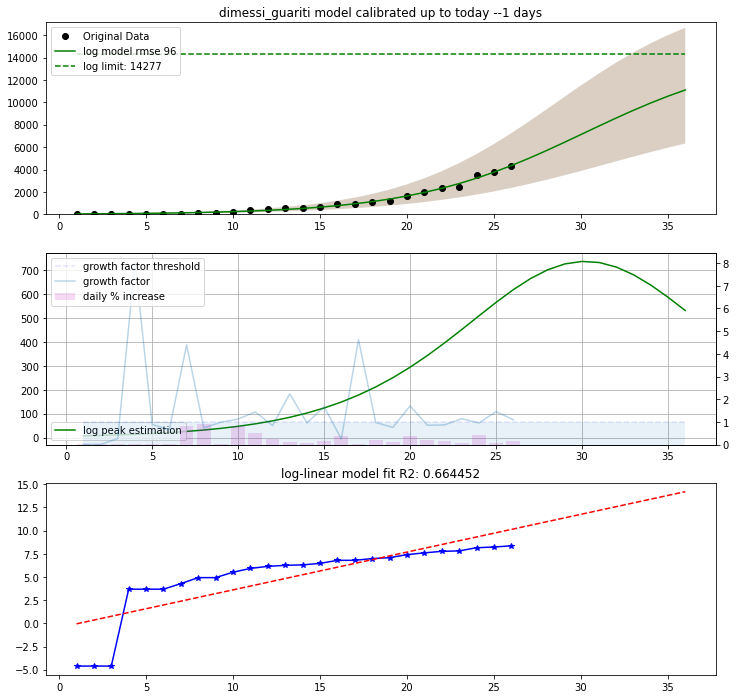

next day prediction for log model:  4996
data
03/16/2020    2368.0
03/17/2020    2485.0
03/18/2020    3488.0
03/19/2020    3778.0
03/20/2020    4295.0
Name: dimessi_guariti, dtype: float64


In [64]:
tools.plot_model(df_reg['Lombardia'].replace(0,0.01), 'dimessi_guariti', backward_fit=-1, forward_look=10, plotlimit=True, 
                 show_pol=False, show_exp=False)

### Lombardy evolution for provinces

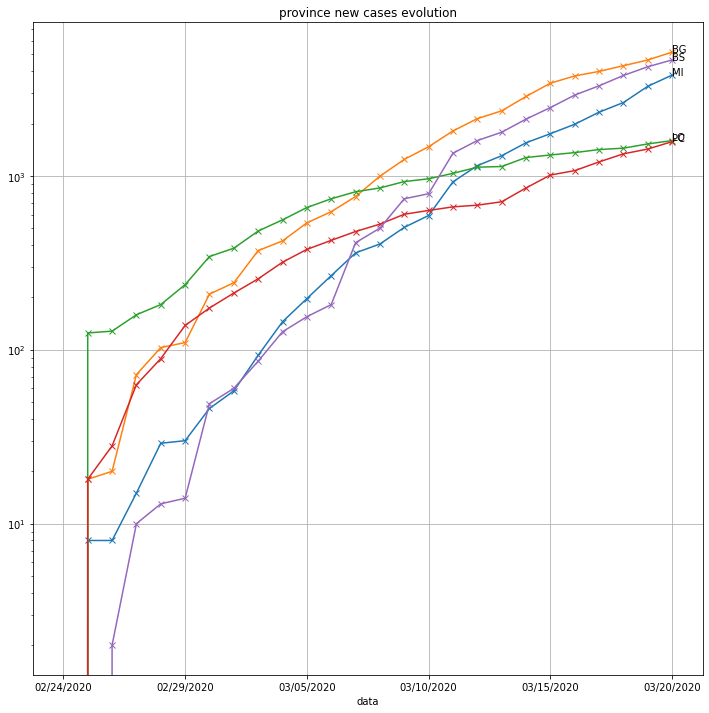

In [87]:
prov_analysis = df_prov.reset_index().pivot_table(index='data', columns='sigla_provincia', 
            values='totale_casi')[['MI', 'BG', 'LO', 'PC', 'BS']]
prov_analysis.plot(kind='line', style='x-', figsize=(12,12), legend=False)
for label in ['MI', 'BG', 'LO', 'PC', 'BS']:
    plt.annotate(label, xy=(len(prov_analysis)-1, prov_analysis[label].iloc[-1]),textcoords='data')
plt.title('province new cases evolution')
plt.grid()
plt.yscale('log')

### china comparison

C:\Users\Maurizio Spadaccino\Documents\projects\coronavirus\notebooks\tools.py:112: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



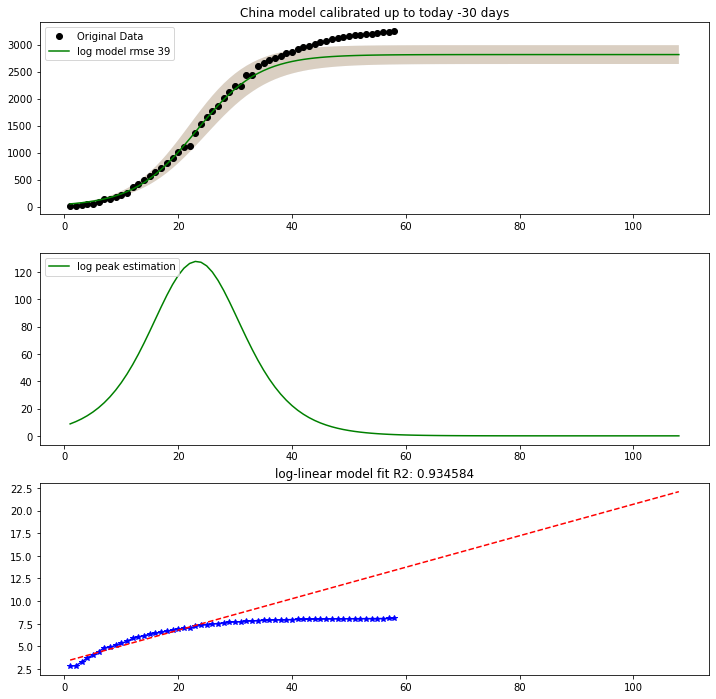

next day prediction for log model:  2811
2020-03-15    3203.0
2020-03-16    3217.0
2020-03-17    3230.0
2020-03-18    3241.0
2020-03-19    3249.0
Name: China, dtype: float64


In [66]:
china_deaths = df_world_deaths[df_world_deaths['Country/Region']=='China'].groupby('Country/Region').sum().drop('Lat',1).drop('Long',1).T.iloc[:-1]
china_deaths.index = pd.to_datetime(china_deaths.index)
tools.plot_model(china_deaths, 'China', backward_fit=30, forward_look=50, plotdifferential=True, plotlimit=False, show_pol=False, show_exp=False)

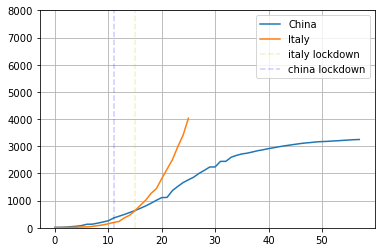

In [67]:
df_compare = pd.DataFrame(data=pd.concat([china_deaths.reset_index(drop=True), df_naz['deceduti'].reset_index(drop=True)], 
                            axis=1))
df_compare.columns = ['China','Italy']
df_compare.plot()
plt.ylim(0,8000)
plt.grid()
plt.axvline(x=15, label='italy lockdown', alpha=0.2, color='y', linestyle='--')
plt.axvline(x=11, label='china lockdown', alpha=0.2, color='b', linestyle='--')
plt.legend()

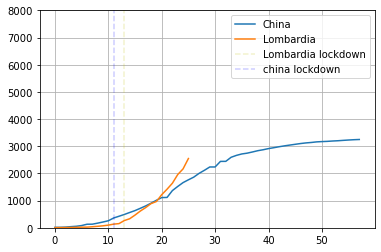

In [68]:
df_compare = pd.DataFrame(data=pd.concat([china_deaths.reset_index(drop=True), 
                    df_reg['Lombardia']['deceduti'].reset_index(drop=True)], axis=1))
df_compare.columns = ['China','Lombardia']
df_compare.plot()
plt.ylim(0,8000)
plt.grid()
plt.axvline(x=13, label='Lombardia lockdown', alpha=0.2, color='y', linestyle='--')
plt.axvline(x=11, label='china lockdown', alpha=0.2, color='b', linestyle='--')
plt.legend()

## World comparisons

In [69]:
countries = ['Spain', 'Italy', 'Germany', 'France', 'United Kingdom', 'US']
df_countries = pd.DataFrame()
df_countries_stripped = pd.DataFrame()
for country in countries:
    print(country)
    df_countries = pd.concat((df_countries, df_world_deaths.groupby('Country/Region').sum().loc[country].drop(['Lat','Long'],0)), 1)
    temp = df_world_deaths.groupby('Country/Region').sum().loc[country].drop(['Lat','Long'],0).reset_index(drop=True)    
    temp = temp.loc[~(temp==0)].reset_index(drop=True).iloc[:-1]    
    df_countries_stripped= pd.concat((df_countries_stripped,  temp), 1)
df_countries.columns = countries
#df_countries_stripped = pd.concat((pd.DataFrame(np.zeros((1,len(countries))), columns=countries), df_countries_stripped),0).reset_index(drop=True)

Spain
Italy
Germany
France
United Kingdom
US


In [70]:
start_dates = {}
start_dates['Spain'] = '3/3/20'
start_dates['Italy'] = '2/21/20'
start_dates['Germany'] = '3/9/20'
start_dates['France'] = '2/25/20'
start_dates['United Kingdom'] = '3/5/20'
start_dates['US'] = '3/1/20'

country_offsets = {}
country_offsets['Spain'] = 0
country_offsets['Italy'] = 0
country_offsets['Germany'] = 0
country_offsets['France'] = -14
country_offsets['United Kingdom'] = 0
country_offsets['US'] = -2

In [71]:
populations.loc['US'] = populations.loc['United States']

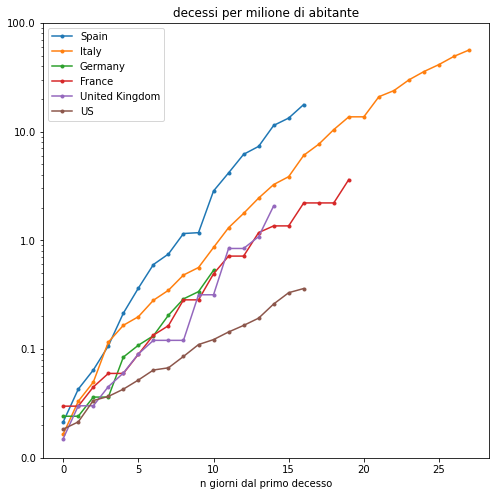

In [72]:
fig, ax = plt.subplots(figsize=(8,8))
for country in countries:
    plt.plot(df_countries_stripped[country].shift(country_offsets[country]) / populations.loc[country] *1e6, '.-', label=country, )
plt.title('decessi per milione di abitante')
plt.xlabel('n giorni dal primo decesso')
plt.yscale('log')
plt.ylim(bottom=0.01, top=100)
from matplotlib.ticker import ScalarFormatter
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_major_formatter(ScalarFormatter())
plt.legend()

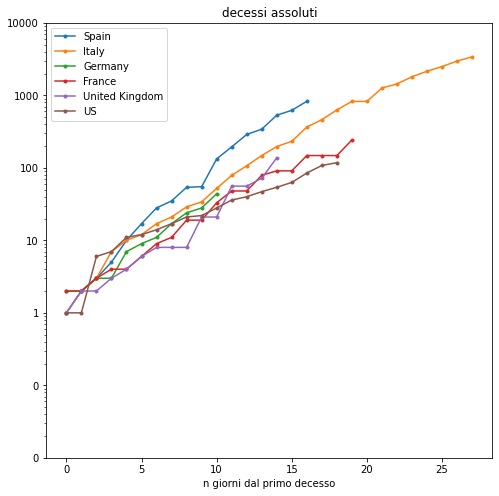

In [73]:
fig, ax = plt.subplots(figsize=(8,8))
for country in countries:
    if country=='France':
        plt.plot(df_countries_stripped[country].shift(-14), '.-', label=country)
    else:
        plt.plot(df_countries_stripped[country], '.-', label=country)
plt.title('decessi assoluti')
plt.xlabel('n giorni dal primo decesso')
plt.yscale('log')
plt.ylim(bottom=0.01, top=10000)
from matplotlib.ticker import ScalarFormatter
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_major_formatter(ScalarFormatter())
plt.legend()

## The SIR epidemic model

(see https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/ and 
https://www.r-bloggers.com/epidemiology-how-contagious-is-novel-coronavirus-2019-ncov/)

A simple mathematical description of the spread of a disease in a population is the so-called SIR model, which divides the (fixed) population of N individuals into three "compartments" which may vary as a function of time, t:

S(t) are those susceptible but not yet infected with the disease;
I(t) is the number of infectious individuals;
R(t) are those individuals who have recovered from the disease and now have immunity to it.
The SIR model describes the change in the population of each of these compartments in terms of two parameters, β and γ. β describes the effective contact rate of the disease: an infected individual comes into contact with βN other individuals per unit time (of which the fraction that are susceptible to contracting the disease is S/N). γ is the mean recovery rate: that is, 1/γ is the mean period of time during which an infected individual can pass it on.

The differential equations describing this model were first derived by Kermack and McKendrick [Proc. R. Soc. A, 115, 772 (1927)]:

$dSdt=−βSI/N$ <br>
$dIdt=β(SI)/N−γI$ <br>
$dRdt=γI$ <br>

The following Python code integrates these equations for a disease characterised by parameters β=0.2, 1/γ=10days in a population of N=1000 (perhaps 'flu in a school). The model is started with a single infected individual on day 0: I(0)=1. The plotted curves of S(t), I(t) and R(t) are styled to look a bit nicer than Matplotlib's defaults.

In [74]:
# SIR model differential equations
def deriv(y, t, N, beta, gamma, theta):
    S, I, R, D = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    dDdt = theta * I
    return dSdt, dIdt, dRdt, dDdt

def SIRModel_solver(t, beta, gamma, theta):
    return SIRModel(t, beta, gamma, theta)[3] # returns just D for optimizer

def SIRModel(t, beta, gamma, theta):
    # Initial conditions vector
    y0 = S0, I0, R0, D0
    # Integrate the SIR equations over time t
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, theta))
    S, I, R, D = ret.T
    return S, I, R, D

def SIRModel_diff_ev_solver(params):
    beta, gamma, theta = params
    return np.mean(np.abs(SIRModel_solver(x_fit, beta, gamma, theta) - y_fit))

### toy example

beta:  0.2
gamma:  0.1
theta:  0.015
r0:  2.0
mean period of time of infection:  10.0


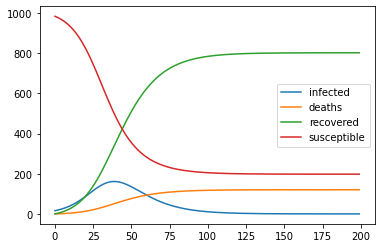

In [75]:
N = 1000 # total population Italy
I0 = 16 # Initial number of infected people (10x official estimates hypothesis)
R0 = 0 # Initial number of recovered
S0 = N - I0 - R0 # Initial susceptible population to infection.
D0 = 0 # number of deaths at initial time

params = (0.2, 0.1, 0.015)
S, I , R, D = SIRModel(range(200), *params)
print('beta: ', params[0])
print('gamma: ', params[1])
print('theta: ', params[2])
print('r0: ', params[0]/params[1])
print('mean period of time of infection: ', 1/params[1])

plt.plot(I, label='infected')
plt.plot(D, label='deaths')
plt.plot(R, label='recovered')
plt.plot(S, label='susceptible')
#plt.yscale('log')
#ax.yaxis.set_major_formatter(ScalarFormatter())

#plt.ylim(0,10000)
plt.legend()

### fit to official death data

calibrating with genetic algorithm...
beta:  4.812485121249349
gamma:  4.560046823489471
theta:  0.0048952655305568955
r0:  1.055358707384216
mean period of time of infection:  0.2192959938149874
max number of infections  85157.79545475691
max number of deaths  6696.685129620527
mae  27.1938563558738


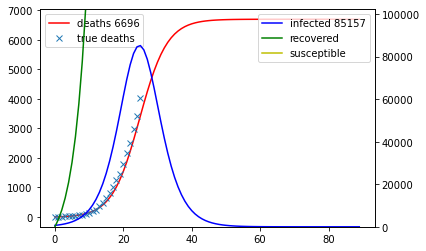

In [82]:
use_differential_evolution = True
cases_multiplier = 3
df = pd.read_csv('../../external_data/ProtezioneCivile/COVID-19/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv').drop('stato',1)
y_fit = df['deceduti'].values
x_fit = np.linspace(0, len(y_fit), len(y_fit))
N = 60431283 # total population Italy
I0 = cases_multiplier*df['totale_attualmente_positivi'].iloc[0] # Initial number of infected people (10x official estimates hypothesis)
R0 = 0 #df['dimessi_guariti'].iloc[0] # Initial number of recovered
S0 = N - I0 - R0 # Initial susceptible population to infection.
D0 = 0 # number of deaths at initial time

bounds = [(0,5), (0, 5), (0, 5)]
if use_differential_evolution:
    print('calibrating with genetic algorithm...')
    optimization = differential_evolution(SIRModel_diff_ev_solver, bounds)
    params = optimization.x
else:
    params, covariances = curve_fit(f=SIRModel_solver, xdata=x_fit, ydata=y_fit, method='trf', bounds=bounds[0])
S, I , R, D = SIRModel(range(90), *params)
print('beta: ', params[0])
print('gamma: ', params[1])
print('theta: ', params[2])
print('r0: ', params[0]/params[1])
print('mean period of time of infection: ', 1/params[1])
print('max number of infections ', np.max(I))
print('max number of deaths ', np.max(D))
print('mae ', np.mean(np.abs(y_fit - SIRModel_solver(x_fit, *params))))
fig, ax1 = plt.subplots()
ax1.plot(D,'r', label='deaths '+str(int(np.max(D))))
ax1.plot(y_fit,'x', label='true deaths')
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
plt.ylim(0,1.2*np.max(I))
ax2.plot(I,'b', label='infected '+str(int(np.max(I))))
ax2.plot(R,'g', label='recovered')
ax2.plot(S,'y', label='susceptible')


ax2.legend()

calibrating with genetic algorithm...
beta:  2.670559130855131
gamma:  2.4148545646111543
theta:  0.0014141426556641935
r0:  1.1058881847342847
mean period of time of infection:  0.41410361296893355
max number of infections  287418.23357014806
max number of deaths  6564.007105420608
mae  20.015289666188046

In [28]:
df_china = pd.DataFrame()
df_china['deaths'] = df_world_deaths.groupby('Country/Region').sum().loc['China'].drop(['Lat','Long'],0)
df_china['recovered'] = df_world_recovered.groupby('Country/Region').sum().loc['China'].drop(['Lat','Long'],0)
df_china['confirmed'] = df_world_confirmed.groupby('Country/Region').sum().loc['China'].drop(['Lat','Long'],0)

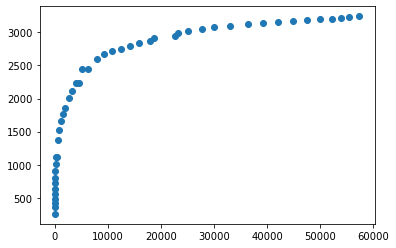

In [177]:
plt.scatter(df_china['recovered'].shift(10).drop(['pop']), df_china['deaths'].drop(['pop']))

In [173]:
pd.concat([df_china['recovered'].shift(10).drop(['pop']), df_china['recovered'].drop(['pop']), df_china['deaths'].drop(['pop'])], 1)

,recovered,recovered,deaths
1/22/20,NaN,28.0,17.0
1/23/20,NaN,30.0,18.0
1/24/20,NaN,36.0,26.0
1/25/20,NaN,39.0,42.0
1/26/20,NaN,49.0,56.0
1/27/20,NaN,58.0,82.0
1/28/20,NaN,101.0,131.0
1/29/20,NaN,120.0,133.0
1/30/20,NaN,135.0,171.0
1/31/20,NaN,214.0,213.0


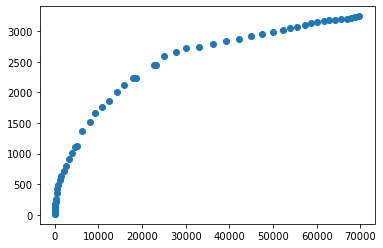

In [151]:
plt.scatter(df_china['recovered'].shift(0).drop(['pop']), df_china['deaths'].drop(['pop']))

In [127]:
import scipy.integrate as integrate
mortality_rate = 0.025
total_deaths =  integrate.quad(lambda x: SIRModel((x,), *optim_params)[1], 0, 100)[0]
print('total ', total_deaths)

total  221000.00000000006


## simulation using Facebook Phrophet Model

In [127]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
c:\anaconda3\envs\coronavirus\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Traceback (most recent call last):
  File "c:\anaconda3\envs\coronavirus\lib\site-packages\matplotlib\axis.py", line 1573, in convert_units
    ret = self.converter.convert(x, self.units, self)
  File "c:\anaconda3\envs\coronavirus\lib\site-packages\matplotlib\category.py", line 61, in convert
    unit.update(values)
  File "c:\

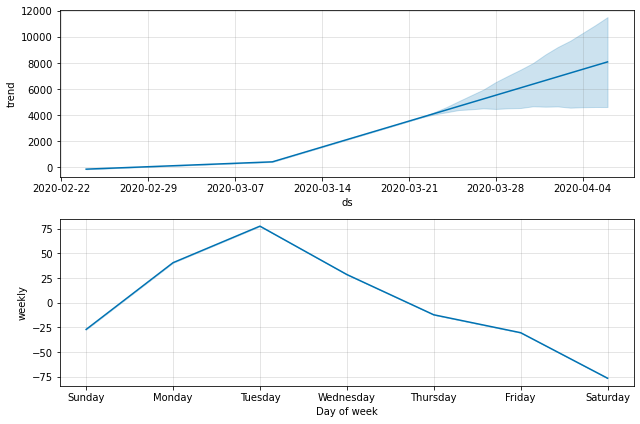

ValueError: view limit minimum -7.930656e+16 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

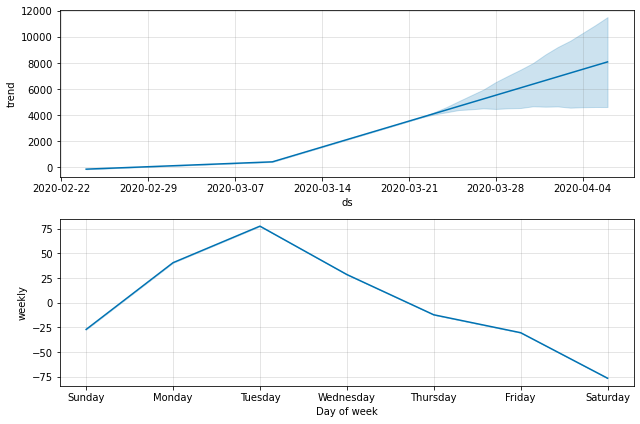

In [128]:

y = 'deceduti'
train_data = pd.DataFrame()
train_data['ds']=df_naz.index
train_data['y']=df_naz[y].reset_index(drop=True).values
growth = 'linear'
cap = 4000
floor = 0
if growth=='logistic':
    train_data['cap'] = cap
    train_data['floor'] = floor

m = Prophet(growth = growth, changepoints=['2020-03-10'], changepoint_prior_scale=0.75)
m.fit(train_data)
future = m.make_future_dataframe(periods=20)
if growth=='logistic':
    future['cap'] = cap
    future['floor'] = floor
forecast = m.predict(future)
fig = m.plot(forecast)

a = add_changepoints_to_plot(fig.gca(), m, forecast)
plt.title('prophet forecast for ' + y)
plt.plot(train_data.set_index('ds')['y'],'r*',label='actual data')
#plt.axvspan(whole_data.iloc[0]['ds'], train_data.iloc[-1]['ds'], alpha=0.15, color='red', label='train period')
#plt.axvspan(test_data.iloc[0]['ds'], test_data.iloc[-1]['ds'], alpha=0.15, color='green', label='test period')
plt.legend()
m.plot_components(forecast)
